# Задача 8. Сравнение методов классификации

** **Дедлайн**: 28.11.2025, 23:59
* Полный балл: 15

## Задача

- [+] Найти данные, на которых интересно будет решать задачу классификации (больше `1000` строк, больше `5` признаков).
- [+] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [+] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [+] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [+] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания для библиотечных реализаций (например, из **sklearn**) четырёх методов классификации.

##### Часть 1 (Поиски Данных и выполнение полезных преобразований)

In [1]:
import pandas as pd

df = pd.read_csv('bank.csv')

print(f"Размер: {df.shape}")

Размер: (4521, 17)


#### Выполняем чистку (убираем дубликаты и пропущенные значения)

In [2]:
duplicates = df.duplicated().sum()
print(f"Найдено дубликатов: {duplicates}")

Найдено дубликатов: 0


Дубликатов не найдено. Отсалсоь толок провести проверку для пропусков

In [3]:
missing_data = df.isnull().sum()
print(f"Найдено пропусков: \n{missing_data}")

Найдено пропусков: 
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Видим, что пропусков не найдено. Видимо хороший датасет нашли.

### Теперь уберем не нужные нам признаки и оставим только 5 признаков и 1000 строк

Я оставлю по моему мнению самые важные признаки для классификации:
- баланс
- возраст
- duration - время последней встричи в секундах
- campaign - количество контактов с этим клиентом до этого (означет, сколько раз банк звонил и предлагал открыть депозит в этой кампании)
- previous - сколько раз уже учавствовал в кампаниях банка
- y - подписался ли на депозит или нет (это данные, которые мы должны пресказать)

Давайте определим наш датасет

In [4]:
df = df[['age', 'balance', 'duration', 'campaign', 'previous', 'y']].head(1000)
print(f"Размер: {df.shape}")

Размер: (1000, 6)


Проведем разведочный анализ, используем визуализацию, сделаем выводы, которые могут быть полезны при дальнейшем решении задачи классификации.

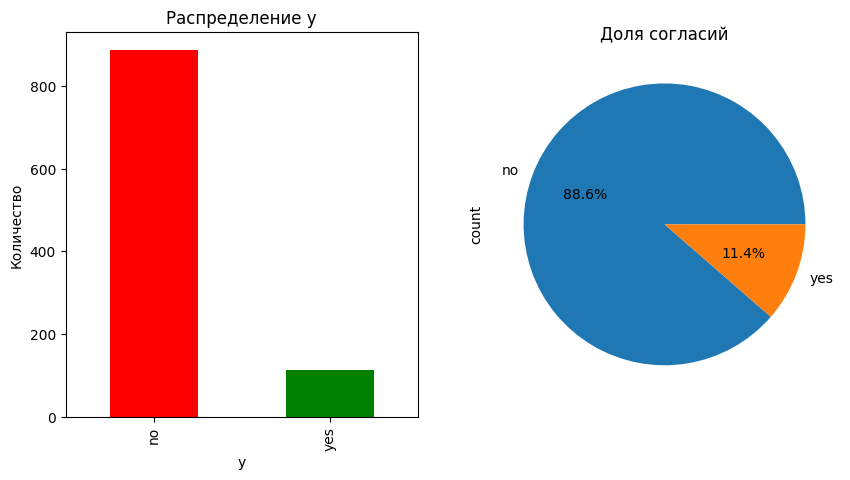

In [5]:
import matplotlib.pyplot as plt

# A graph that shows how many people have signed up for a deposit and how many have not
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['y'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Распределение y')
plt.ylabel('Количество')

# Percentage ratio for or against
plt.subplot(1, 2, 2)
df['y'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Доля согласий')
plt.show()

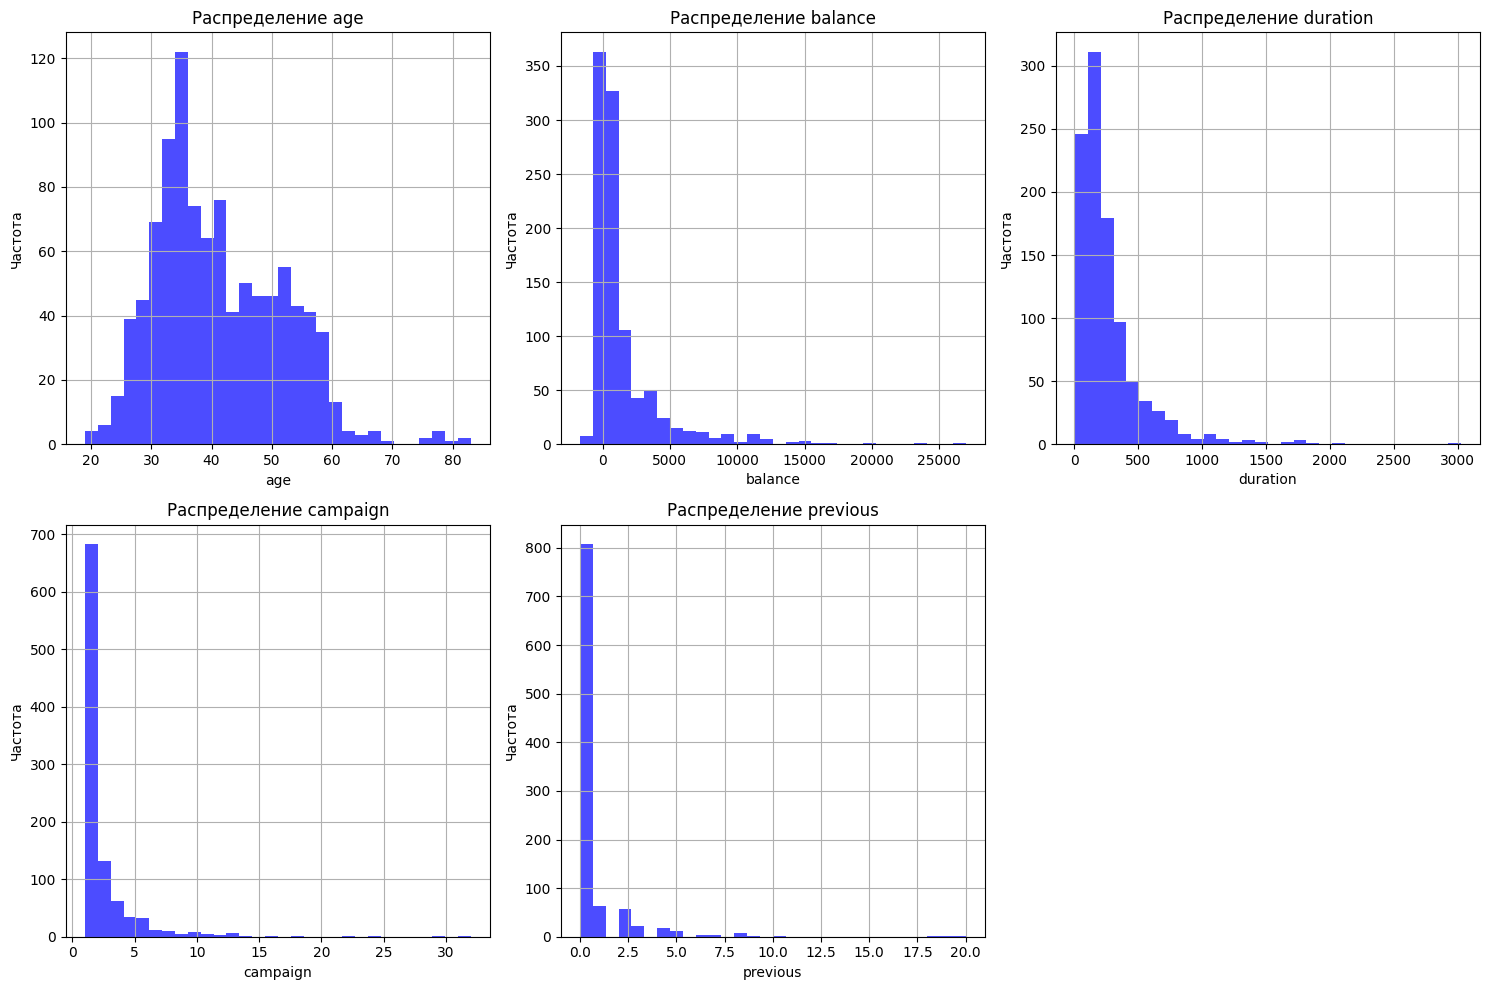

In [6]:
columns_list = df.columns.tolist()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(columns_list[:-1], 1):
    plt.subplot(2, 3, i)
    df[feature].hist(bins=30, alpha=0.7, color='blue')
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    
plt.tight_layout()
plt.show()

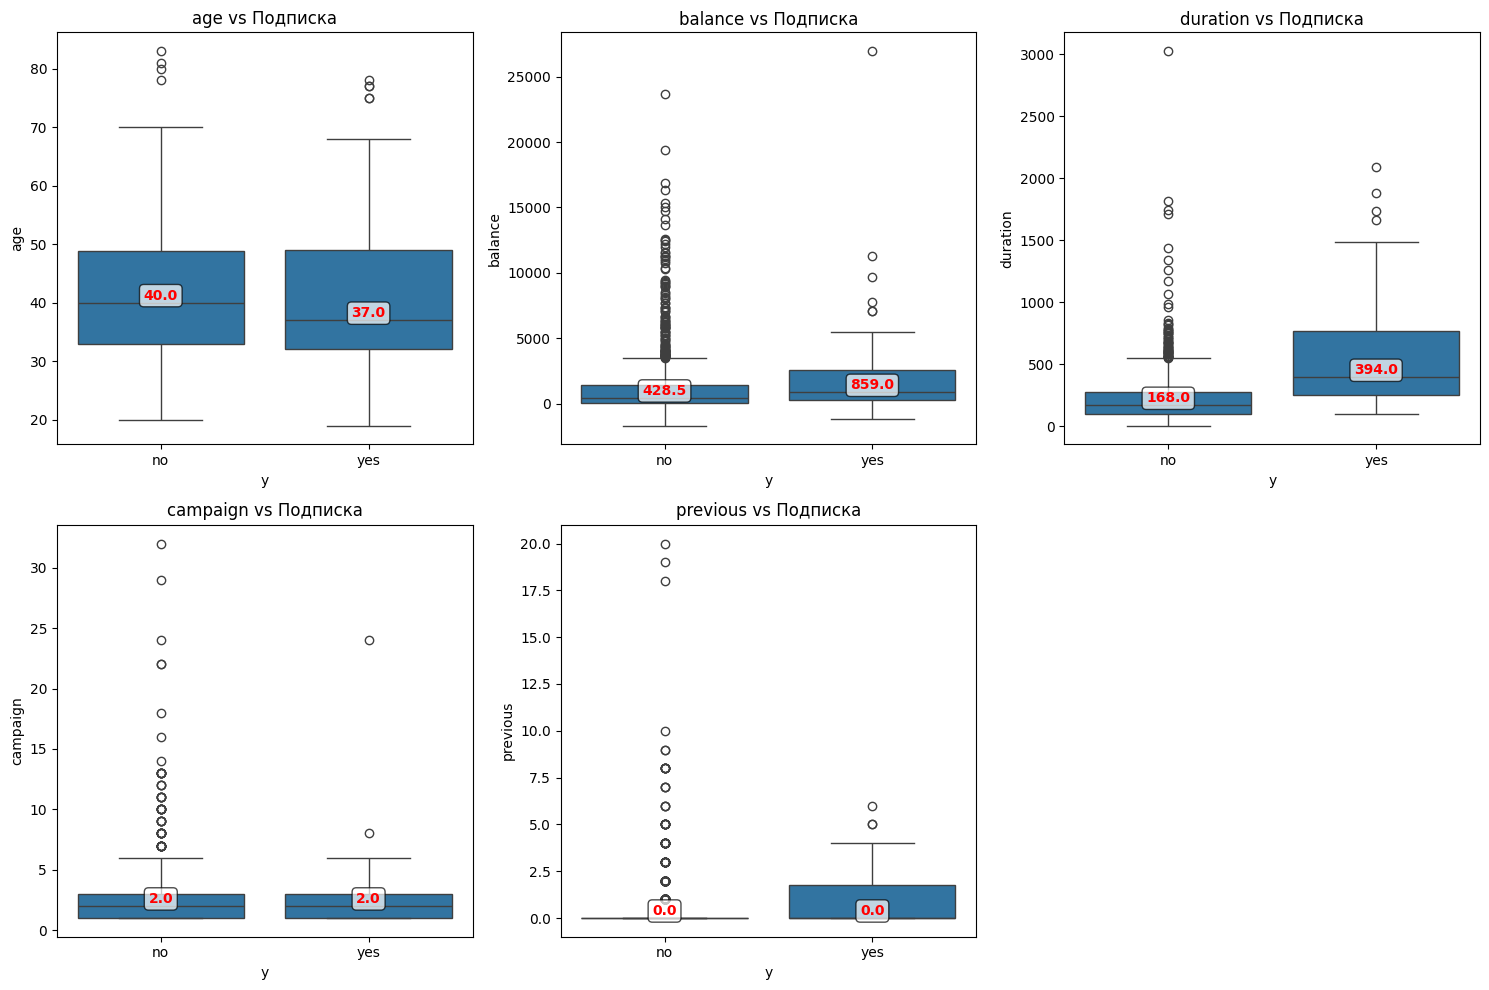

In [7]:
import seaborn as sns
plt.figure(figsize=(15, 10))

for i, (feature, title) in enumerate(zip(columns_list[:-1], columns_list[:-1]), 1):
    plt.subplot(2, 3, i)
    ax = sns.boxplot(data=df, x='y', y=feature)
    plt.title(f'{title} vs Подписка')
    
    medians = df.groupby('y')[feature].median()
    for j, median in enumerate(medians):
        ax.text(j, median, f'{median}', 
                ha='center', va='bottom', fontweight='bold', 
                color='red', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

### Выводы:
- Длительность звонка существенно влияет на то, подписался ли клиент на депозит или нет, обычно длительность звонка, того, кто подписался примерно 400 секунд, что больше 10 минут.
- Впринципе от возраста не зависит то, подписался ли клиент или нет.
- От баланса тоже существенно зависит то, подписался или нет. Средний баланс того, кто подписался почти в два раза больше, тем те, кто отказался.
- Видим, что campaign ничего впринципе не значит, оно не сильно влияет на это.
- Наблюдаем, что от previous тоже многое зависит, хотя среднее значение и там и там одинаково, но если клиент до этого принимал участие в других кампаниях, то шансы того, что он подпишется больше.

Теперь перейдем к подбору гиперпараметров
- буду использовать GridSearchCV для поиска лучших парматров для каждого метода
- буду использовать StratifiedKFold для кросс - валидации
- буду использовать StandardScaler для масштабирования
- буду использовать такие методы классификации: RandomForestClassifier, SVC, LogisticRegression, KNeighborsClassifier 

разделяем данные

In [8]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:5].tolist()]
Y = (df['y'] == 'yes').astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

Теперь создадим словарь с метриками и их гиперпараметрами, с кросс - валидацией и масштабированиен, где оно используется
Почему же я использую pipeline? Потому что так я смогу сразу обучать модель с масштабированием. Операции выполняются поочередно: сначала я масштабирую данные, после уже обучаю модель.

In [11]:
from sklearn.model_selection import  GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

# cross - validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# All models with their hyperparameters
models_config = {
    'Random Forest': {
        'pipeline': Pipeline([
            ('model', RandomForestClassifier(random_state = 42, class_weight = 'balanced'))
        ]),
        'params': {
            'model__n_estimators': [100, 200], # number of trees
            'model__max_depth': [10, 20, None], # maximum tree depth
            'model__min_samples_split': [2, 5], # minimum number of clients to split a node
            'model__min_samples_leaf': [1, 2] # minimum number in the end node
        }
    },
    
    'SVM': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler() # scaling
             ),
            ('model', SVC(random_state = 42, class_weight = 'balanced'))
        ]),
        'params': {
            'model__C': [0.1, 1, 10], # how strictly to follow the training data
            'model__kernel': ['rbf', 'linear'] # kernel
        }
    },
    
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
        ]),
        'params': {
            'model__C': [0.1, 1, 10], # how much should complex models be penalized?
            'model__penalty': ['l1', 'l2'], # How to penalize complex models
            'model__solver': ['liblinear'] # How to find optimal weights
        }
    },
    
    'K-Neighbors': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsClassifier())
        ]),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9], # number of nearest neighbors
            'model__weights': ['uniform', 'distance'], #  how to take into account the voices of neighbors
            'model__metric': ['euclidean', 'manhattan'] # how to measure "similarity"
        }
    }
}

results = {}
best_models = {}

for model_name, config in models_config.items():
    
    # GridSearchCV
    grid_search = GridSearchCV(
        config['pipeline'],
        config['params'],
        cv=cv,
        scoring='f1', # what metric will we use to evaluate the quality
        n_jobs=-1 #  Parallel computing that uses all cores
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    y_pred = grid_search.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_сv_score': grid_search.best_score_,
        'test_accuracy': accuracy,
        'test_f1': f1,
        'test_precision': precision,
        'test_recall': recall,
        'predictions': y_pred
    }

In [12]:
from sklearn.metrics import confusion_matrix

for model_name in best_models.keys():
    model = best_models[model_name]
    
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    
    print(f"\n{model_name}, params: {results[model_name]['best_params']} ")
    print("Факт \\ Предск |   Нет   |   Да    ")
    print(f"    Нет        |   {cm[0,0]}  |   {cm[0,1]}  ")
    print(f"    Да         |   {cm[1,0]}  |   {cm[1,1]:}  ")
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {results[model_name]['test_accuracy']}", f"F1 - score: {results[model_name]['test_f1']}")


Random Forest, params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100} 
Факт \ Предск |   Нет   |   Да    
    Нет        |   167  |   10  
    Да         |   16  |   7  
Accuracy: 0.87 F1 - score: 0.35

SVM, params: {'model__C': 0.1, 'model__kernel': 'rbf'} 
Факт \ Предск |   Нет   |   Да    
    Нет        |   133  |   44  
    Да         |   7  |   16  
Accuracy: 0.745 F1 - score: 0.3855421686746988

Logistic Regression, params: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'} 
Факт \ Предск |   Нет   |   Да    
    Нет        |   145  |   32  
    Да         |   12  |   11  
Accuracy: 0.78 F1 - score: 0.3333333333333333

K-Neighbors, params: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'model__weights': 'uniform'} 
Факт \ Предск |   Нет   |   Да    
    Нет        |   172  |   5  
    Да         |   19  |   4  
Accuracy: 0.88 F1 - score: 0.25


#### Вывод
- Random Forest - Лучший баланс. Accuracy 0.87 - высокая общая точность. F1-score 0.35 - низкий, но лучший среди моделей. Сильные стороны: Находит 7 из 23 реальных депозитов, при этом всего 10 ложных срабатываний. Слабые стороны: Пропускает 16 потенциальных клиентов (высокий False Negative)
- SVM - Оптимальный для банка. Accuracy 0.745 - средняя, но F1-score 0.386 - лучший!. Сильные стороны: Находит 16 из 23 депозитов (наибольшее количество), хороший баланс. Слабые стороны: 44 ложных вызова - самые высокие затраты на маркетинг
- Logistic Regression - Стабильная, но не лучшая. Accuracy 0.78 - хорошая общая точность. F1-score 0.333 - средний показатель. Проблема: Находит только 11 депозитов из 23, пропускает много клиентов
- K-Neighbors - Худший для нашей задачи. Accuracy 0.88 - обманчиво высокая за счет предсказания "нет". F1-score 0.25 - самый низкий, модель практически бесполезна. Критично: Находит всего 4 депозита из 23!

### Общий вывод
- для поиска клиентов для подписания депозитов лучше всего использовать SVM, так как нам важно количество клиентов, которые подписали депозит намного больше, чем ДАЖЕ 44 ложных вызова.